In [119]:

from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import copy
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_folder
from quantum_kernel.code.kernel_measures import kernel_geometry
from quantum_kernel.code.utils import compute_additional_fields

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()

Top

Get the kernel results for the different ml models and dataset.d

In [120]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
dataset_name='fashion-mnist'
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/"+dataset_name,'Sparse_IQPm'),
    ("/mnt/c/Users/lslat/Data/QK_project/results/rbf/"+dataset_name, "rbf"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/laplacian/"+dataset_name, 'laplacian'),
]

for folder, kernel_name in folders:
    if dataset_name in dfs:
        temp = aggregate_folder(folder, dataset_name, kernel_name=kernel_name)[
            dataset_name]
        dfs[dataset_name] = pd.concat([dfs[dataset_name], temp])
    else:
        dfs[dataset_name] = aggregate_folder(
            folder, dataset_name, kernel_name=kernel_name)[dataset_name]

save_folder='/mnt/c/Users/lslat/Data/QK_project/figs/'


For /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/fashion-mnist, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/fashion-mnist/aggregated.p
For /mnt/c/Users/lslat/Data/QK_project/results/rbf/fashion-mnist, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/rbf/fashion-mnist/aggregated.p
For /mnt/c/Users/lslat/Data/QK_project/results/laplacian/fashion-mnist, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/laplacian/fashion-mnist/aggregated.p


Parse the dataframes so that I have the data I want.

In [121]:
df = dfs[dataset_name]
rbf_df = df[(df['kernel_name'] == 'rbf') & (df['dataset_dim'] == 18)]
laplacian_df = df[(df['kernel_name'] == 'laplacian') & (df['dataset_dim'] == 18)]
sparse_iqpm_df = df[(df['kernel_name'] == 'Sparse_IQPm') & (df['dataset_dim'] == 18)]


Find the best performing models

In [122]:
# find the best performing model idx.
best_rbf_idx = np.argmax(rbf_df['test_score'])
best_sparse_iqpm_idx = np.argmax(sparse_iqpm_df['test_score'])
# careful here. can't do the naive rbf_df['test_score'][idx] as its not a list.
print('Best rbf test score: ', rbf_df.iloc[best_rbf_idx]['test_score'])
print('Best sparse iqpm test score: ',
      sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['test_score'])

print('Best rbf training score: ', rbf_df.iloc[best_rbf_idx]['score'])
print('Best sparse iqpm training score: ',sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['score'])


Best rbf test score:  0.9303587579137775
Best sparse iqpm test score:  0.9303587579137775
Best rbf training score:  0.89
Best sparse iqpm training score:  0.85


Compute the geometric difference between the two top performing models.

In [123]:
cK = rbf_df.iloc[best_rbf_idx]['qkern_matrix_train']
qK = sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['qkern_matrix_train']
gd = kernel_geometry.geometric_difference(qK, cK, 0)
gd2 = kernel_geometry.geometric_difference(cK, qK, 0)
print('Geometric diffence between the two models: ', gd)
print('Reversed geometirc difference: ', gd2)

print('Log scaling factor: ',
      sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['log_scaling_factor'])
print('Log interaction scaling factor: ',
      sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['log_int_scaling_factor'])
# Unsure how to proceed with regularization term. They only discuss lambda in the paper for one of the models. What if we have both?


Geometric diffence between the two models:  2204.161687615152
Reversed geometirc difference:  14.141155152426292
Log scaling factor:  -1.8
Log interaction scaling factor:  0.0


Now we find the IQP kernel model with the closest test score to the best performing RBF model.

In [124]:
# Find the closes sparse iqpm model test score.
closest_sparse_iqpm_idx = np.argmin(
    np.abs(sparse_iqpm_df['test_score']-rbf_df.iloc[best_rbf_idx]['test_score']))
# careful here. can't do the naive rbf_df['test_score'][idx] as its not a list.
print('Best rbf test score: ', rbf_df.iloc[best_rbf_idx]['test_score'])
print('Closest sparse iqpm test score: ',sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['test_score'])


print('Log scaling factor: ',
      sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['log_scaling_factor'])
print('Log interaction scaling factor: ',
      sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['log_int_scaling_factor'])


Best rbf test score:  0.9303587579137775
Closest sparse iqpm test score:  0.9303587579137775
Log scaling factor:  -1.8
Log interaction scaling factor:  0.0


Compute the geometric difference between the two similar performing models.

In [125]:
# compute geometric difference between top performing rbf model
cK = rbf_df.iloc[best_rbf_idx]['qkern_matrix_train']
qK = sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['qkern_matrix_train']
gd = kernel_geometry.geometric_difference(qK, cK, 0)
gd2 = kernel_geometry.geometric_difference(cK, qK, 0)
print('Geometric diffence between the two models: ', gd)
print('Reversed geometirc difference: ', gd2)


Geometric diffence between the two models:  2204.161687615152
Reversed geometirc difference:  14.141155152426292


Find the two best performing models for the RBF and the Laplacian kernel

In [126]:
# find the best performing model idx.
best_rbf_idx = np.argmax(rbf_df['test_score'])
best_laplacian_idx = np.argmax(laplacian_df['test_score'])
# careful here. can't do the naive rbf_df['test_score'][idx] as its not a list.
print('Best rbf test score: ', rbf_df.iloc[best_rbf_idx]['test_score'])
print('Best laplacian test score: ',      laplacian_df.iloc[best_laplacian_idx]['test_score'])

print('Best rbf training score: ', rbf_df.iloc[best_rbf_idx]['score'])
print('Best laplacian training score: ',laplacian_df.iloc[best_laplacian_idx]['score'])


Best rbf test score:  0.9303587579137775
Best laplacian test score:  0.9256858607175158
Best rbf training score:  0.89
Best laplacian training score:  0.925


Compute the geometric difference between teh top performing RBF and Laplacian models.

In [127]:
cKr = rbf_df.iloc[best_rbf_idx]['qkern_matrix_train']
cKl = laplacian_df.iloc[best_laplacian_idx]['qkern_matrix_train']
gd = kernel_geometry.geometric_difference(cKr, cKl, 0)
gd2 = kernel_geometry.geometric_difference(cKl, cKr, 0)
print('Geometric diffence between the two models: ', gd)
print('Reversed geometirc difference: ', gd2)


Geometric diffence between the two models:  8176.322695787699
Reversed geometirc difference:  15.329704598983346


Examining geometric gifference as a function of hyperparameter for the RBF and Laplacian kernels

In [128]:
df1 = rbf_df[['gamma', 'qkern_matrix_train']]
df2 = laplacian_df[['gamma', 'qkern_matrix_train']]
# compute the metric matrix and the list of sorted hyperparameters
h1s, h2s, metric_matrix = kernel_geometry.compute_metric_matrix(df1, df2, metric='geometric_difference')
# compute the reverse
rh1s, rh2s, rmetric_matrix = kernel_geometry.compute_metric_matrix(df2, df1, metric='geometric_difference')

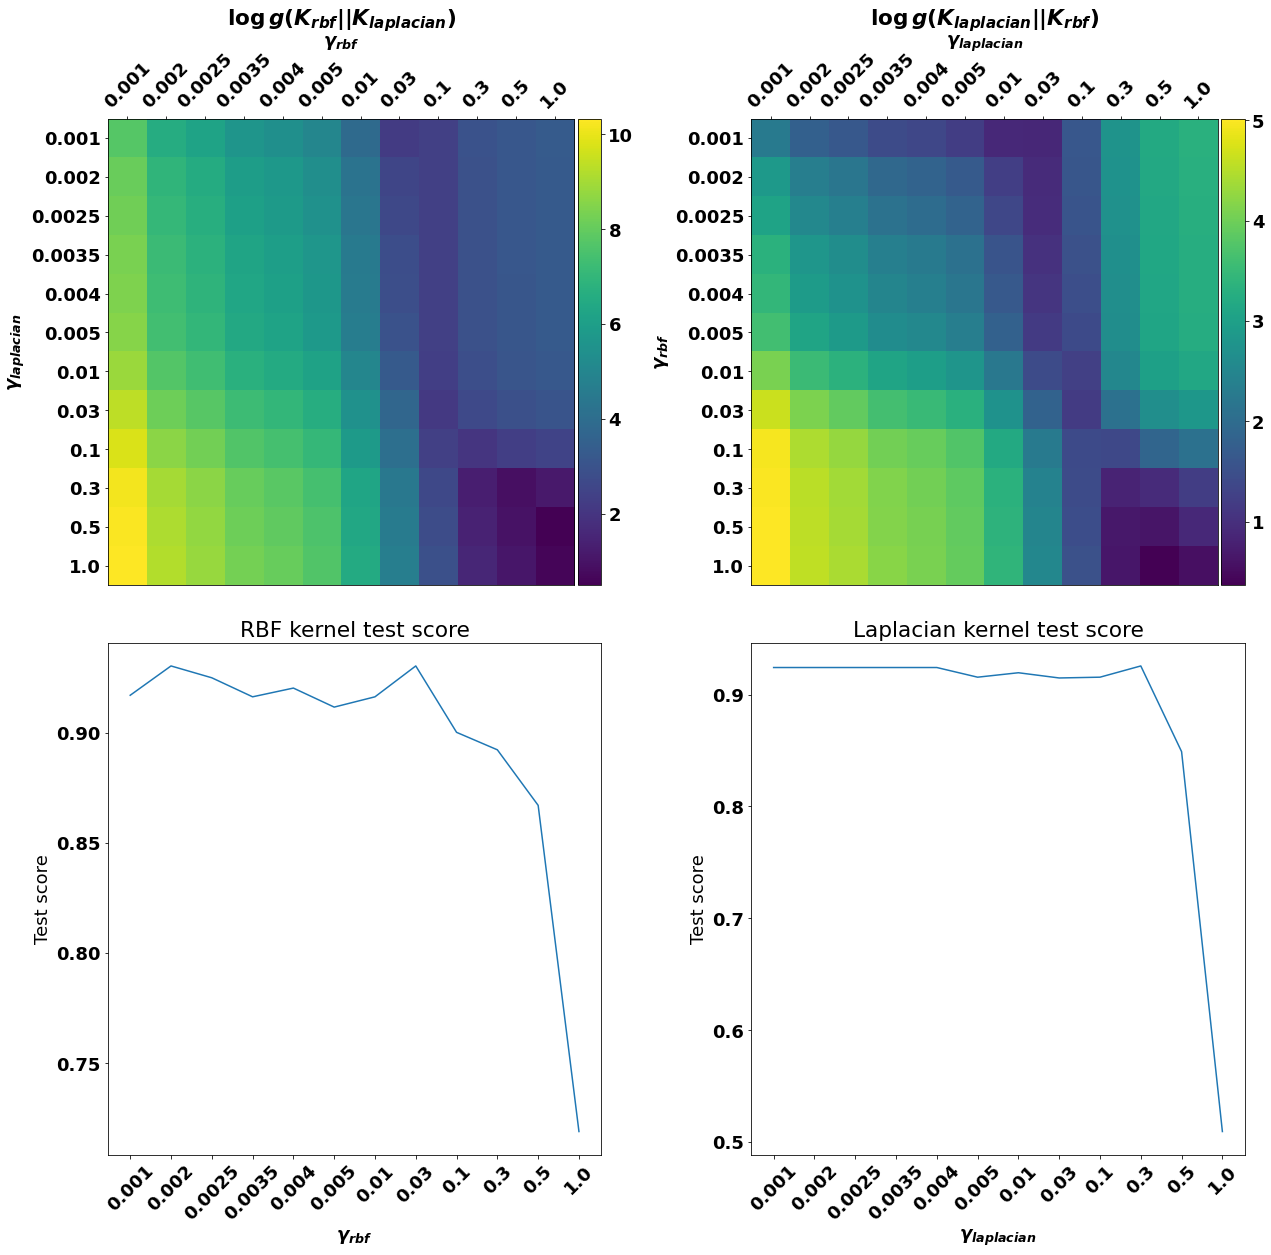

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
# Plot the geometric difference matrix
ax = axs[0][0]
img = ax.imshow(np.log(metric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(h2s.shape[0]), minor=False)
ax.set_yticklabels(h2s)
ax.set_ylabel(r'$\gamma_{laplacian}$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$\log{g(K_{rbf}||K_{laplacian})}$')
# Now plot the reverse geometric difference matrix
ax = axs[0][1]
img = ax.imshow(np.log(rmetric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(rh1s.shape[0]), minor=False)
ax.set_xticklabels(rh1s, rotation=45)
ax.set_xlabel(r'$\gamma_{laplacian}$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(rh2s.shape[0]), minor=False)
ax.set_yticklabels(rh2s)
ax.set_ylabel(r'$\gamma_{rbf}$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$\log{g(K_{laplacian}||K_{rbf})}$')
# Plot the test score as a function of gamma for the RBF kernel.
ax = axs[1][0]
x = h1s
y = np.array([rbf_df['test_score'].loc[rbf_df['gamma'] == h1].values[0]
             for h1 in h1s])
img = ax.plot(y)

ax.set_xticks(np.arange(rh1s.shape[0]), minor=False)
ax.set_xticklabels(rh1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')

ax.set_ylabel('Test score')

ax.set_title('RBF kernel test score')
# Plot the test score as a function of gamma for the Laplacian Kernel.
ax = axs[1][1]
x = rh1s
y = np.array([laplacian_df['test_score'].loc[laplacian_df['gamma']
             == rh2].values[0] for rh2 in rh2s])
img = ax.plot(y)

ax.set_xticks(np.arange(rh1s.shape[0]), minor=False)
ax.set_xticklabels(rh1s, rotation=45)
ax.set_xlabel(r'$\gamma_{laplacian}$')

ax.set_ylabel('Test score')

ax.set_title('Laplacian kernel test score')

####
# plt.subplots_adjust(hspace=-0.6,wspace=0.4)
fig.tight_layout()
fig.savefig(f'{save_folder}{dataset_name}_geometric_difference_rbf_lap.pdf')


Examining geometric distance as a function of hyperparameter for the RBF and Laplacian kernels

In [130]:
df1 = rbf_df[['gamma', 'qkern_matrix_train']]
df2 = laplacian_df[['gamma', 'qkern_matrix_train']]
# compute the metric matrix and the list of sorted hyperparameters
h1s, h2s, metric_matrix = kernel_geometry.compute_metric_matrix(df1, df2, metric='geometric_distance')


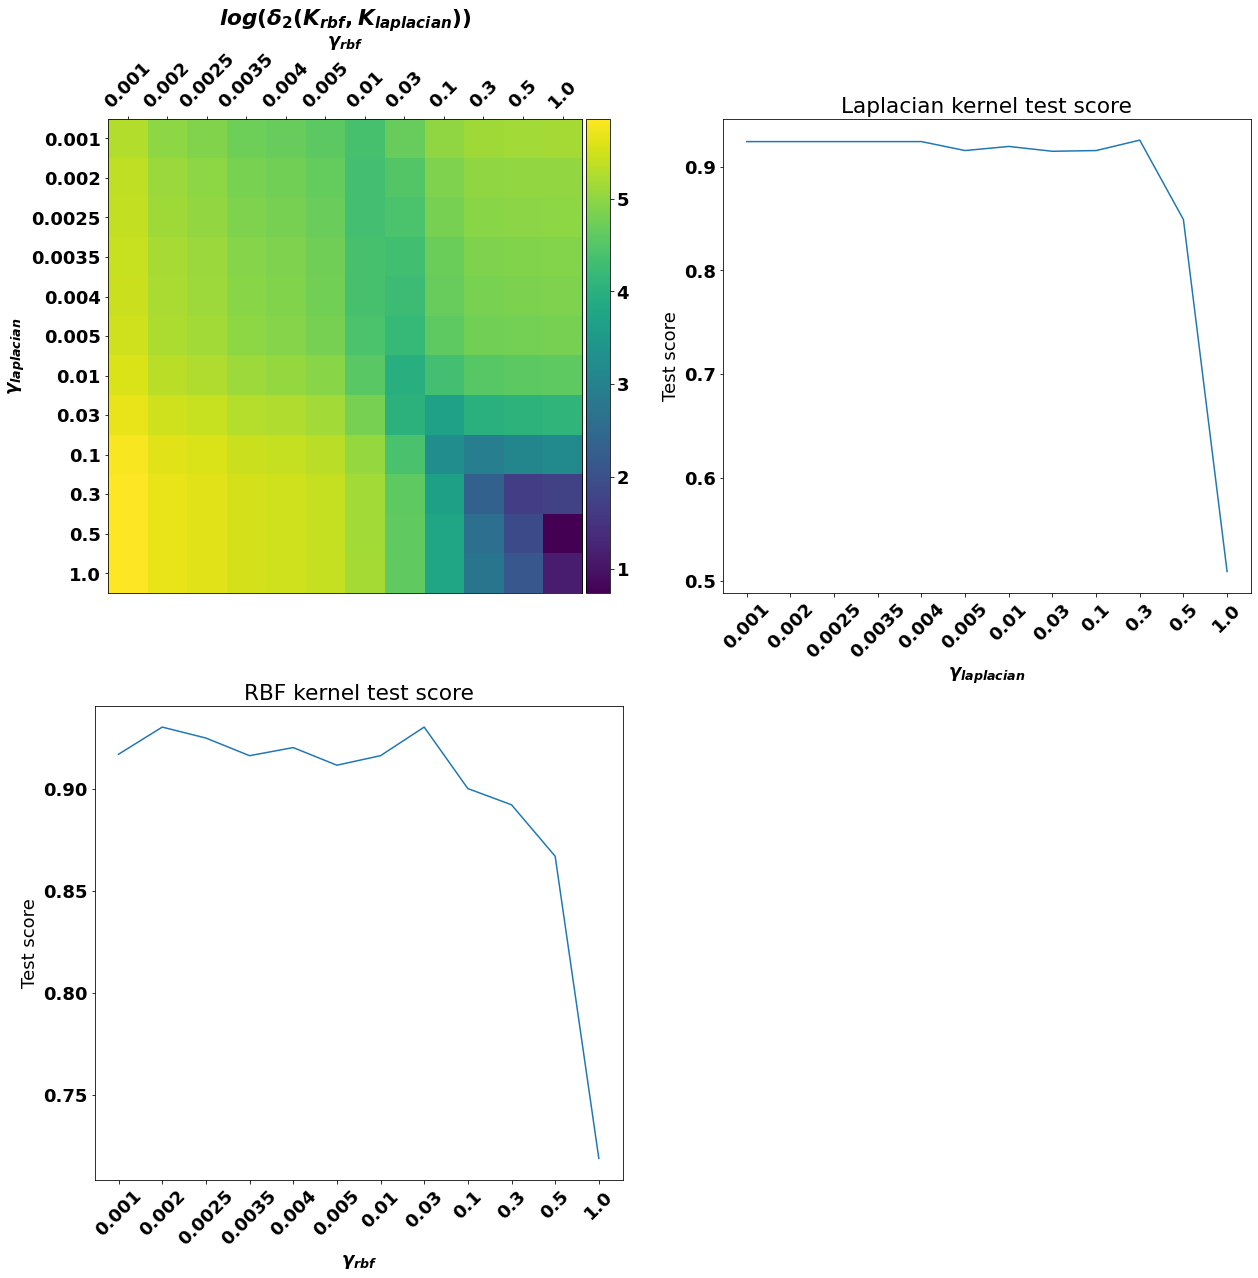

In [131]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
# Plot the geometric difference matrix
ax = axs[0][0]
img = ax.imshow(np.log(metric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(h2s.shape[0]), minor=False)
ax.set_yticklabels(h2s)
ax.set_ylabel(r'$\gamma_{laplacian}$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$log(\delta_{2}{(K_{rbf},K_{laplacian})})$')
# Plot the test score as a function of gamma for the RBF kernel.
ax = axs[1][0]
x = h1s
y = np.array([rbf_df['test_score'].loc[rbf_df['gamma'] == h1].values[0]
             for h1 in h1s])
img = ax.plot(y)

ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')

ax.set_ylabel('Test score')

ax.set_title('RBF kernel test score')
# Plot the test score as a function of gamma for the Laplacian Kernel.
ax = axs[0][1]
x = h2s
y = np.array([laplacian_df['test_score'].loc[laplacian_df['gamma']
             == h2].values[0] for h2 in h2s])
img = ax.plot(y)

ax.set_xticks(np.arange(h2s.shape[0]), minor=False)
ax.set_xticklabels(h2s, rotation=45)
ax.set_xlabel(r'$\gamma_{laplacian}$')

ax.set_ylabel('Test score')

ax.set_title('Laplacian kernel test score')

####
# plt.subplots_adjust(hspace=-0.6,wspace=0.4)
fig.delaxes(axs[1][1])
fig.tight_layout()
fig.savefig(f'{save_folder}{dataset_name}_geometric_distance_rbf_lap.pdf')

Comparing grassmann distance between the subpsaces formed from the largest eigenvectors of RBF and Laplacian kernels.

In [132]:
df1 = rbf_df[['gamma', 'qkern_matrix_train']]
df2 = laplacian_df[['gamma', 'qkern_matrix_train']]
# compute the metric matrix and the list of sorted hyperparameters
h1s, h2s, metric_matrix = kernel_geometry.compute_metric_matrix(df1, df2,metric='grassmann_distance',k=3)

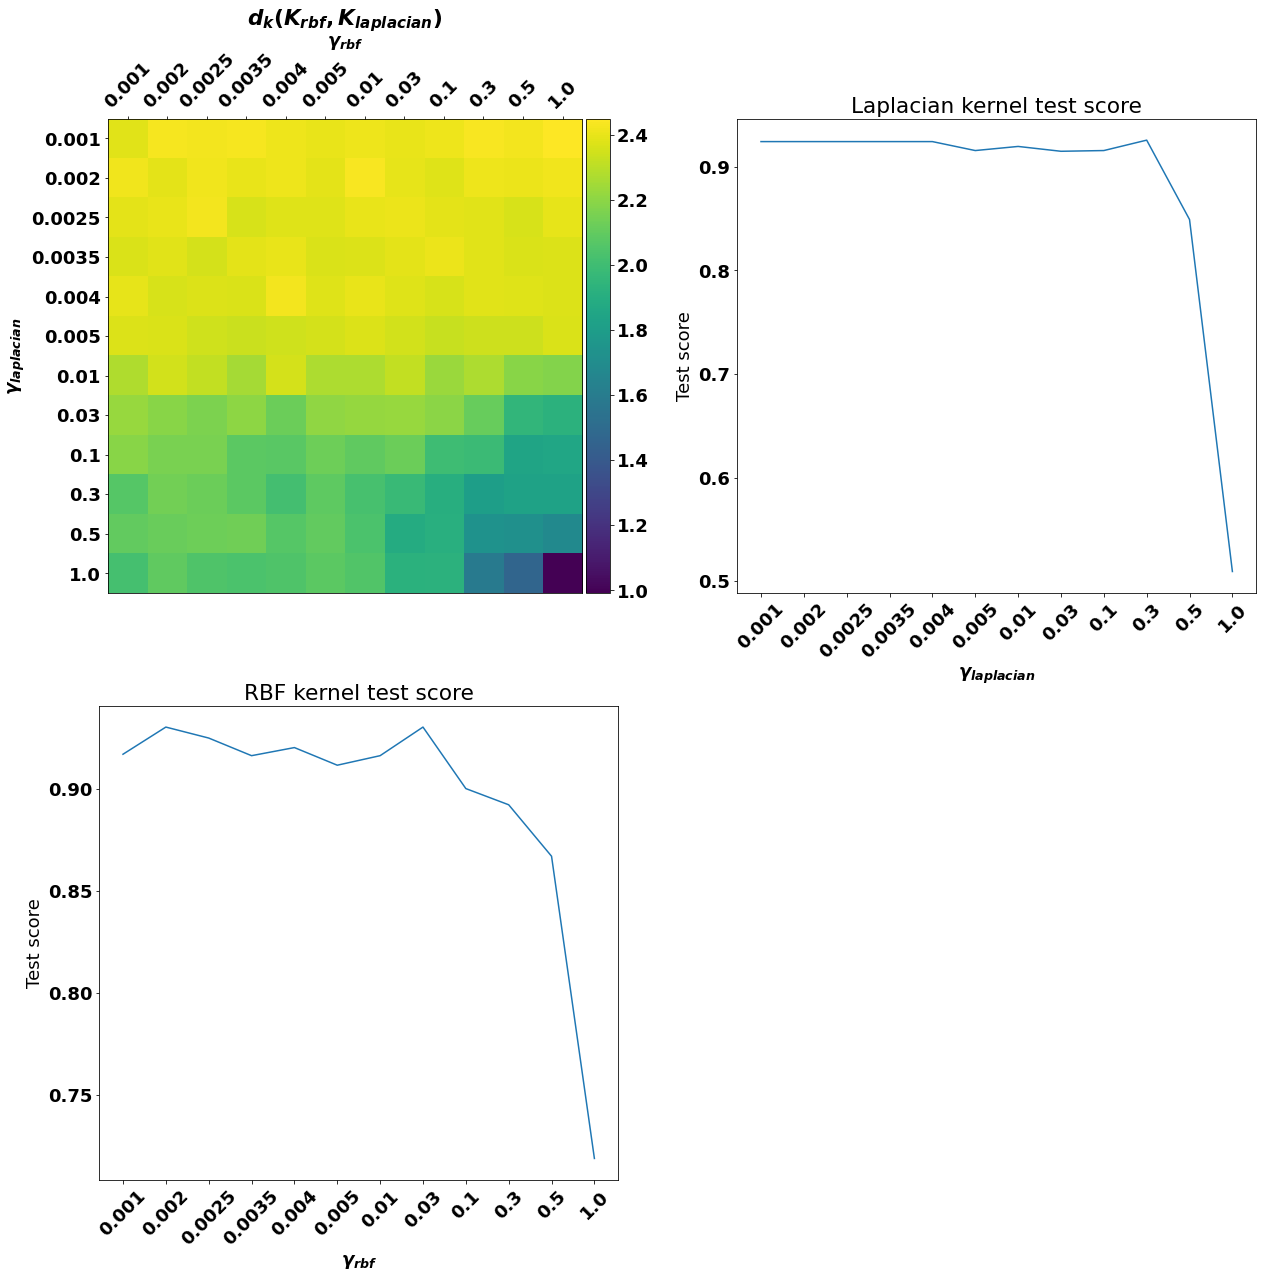

In [133]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
# Plot the geometric difference matrix
ax = axs[0][0]
img = ax.imshow(metric_matrix)

ax.xaxis.tick_top()
ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(h2s.shape[0]), minor=False)
ax.set_yticklabels(h2s)
ax.set_ylabel(r'$\gamma_{laplacian}$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$d_{k}{(K_{rbf},K_{laplacian}})$')
# Plot the test score as a function of gamma for the RBF kernel.
ax = axs[1][0]
x = h1s
y = np.array([rbf_df['test_score'].loc[rbf_df['gamma'] == h1].values[0] for h1 in h1s])
img = ax.plot(y)

ax.set_xticks(np.arange(h2s.shape[0]), minor=False)
ax.set_xticklabels(h2s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')

ax.set_ylabel('Test score')

ax.set_title('RBF kernel test score')
# Plot the test score as a function of gamma for the Laplacian Kernel.
ax = axs[0][1]
x = h1s
y = np.array([laplacian_df['test_score'].loc[laplacian_df['gamma']
             == h1].values[0] for h1 in h1s])
img = ax.plot(y)

ax.set_xticks(np.arange(h2s.shape[0]), minor=False)
ax.set_xticklabels(h2s, rotation=45)
ax.set_xlabel(r'$\gamma_{laplacian}$')

ax.set_ylabel('Test score')

ax.set_title('Laplacian kernel test score')

####
# plt.subplots_adjust(hspace=-0.6,wspace=0.4)
fig.delaxes(axs[1][1])
fig.tight_layout()
fig.savefig(f'{save_folder}{dataset_name}_grassmann_distance_rbf_lap.pdf')


Perform the same test comparing the geometric diifference and the geometric distance with the IQP Kernel with the RBF kernel.
In this test, we fix the second hyperparameter (the interaction hyperparameter) of the  sparse IQP kernel to 1.

In [134]:
iqp_df = sparse_iqpm_df[(sparse_iqpm_df['log_int_scaling_factor'] == 0.0) & (sparse_iqpm_df['density']==17)]

df1 = rbf_df[['gamma', 'qkern_matrix_train']]
df2 = iqp_df[['log_scaling_factor', 'qkern_matrix_train']]
# compute the metric matrix and the list of sorted hyperparameters
h1s, h2s, metric_matrix = kernel_geometry.compute_metric_matrix(df1, df2, metric='geometric_difference')
# compute the reverse
rh1s, rh2s, rmetric_matrix = kernel_geometry.compute_metric_matrix(df2, df1, metric='geometric_difference')


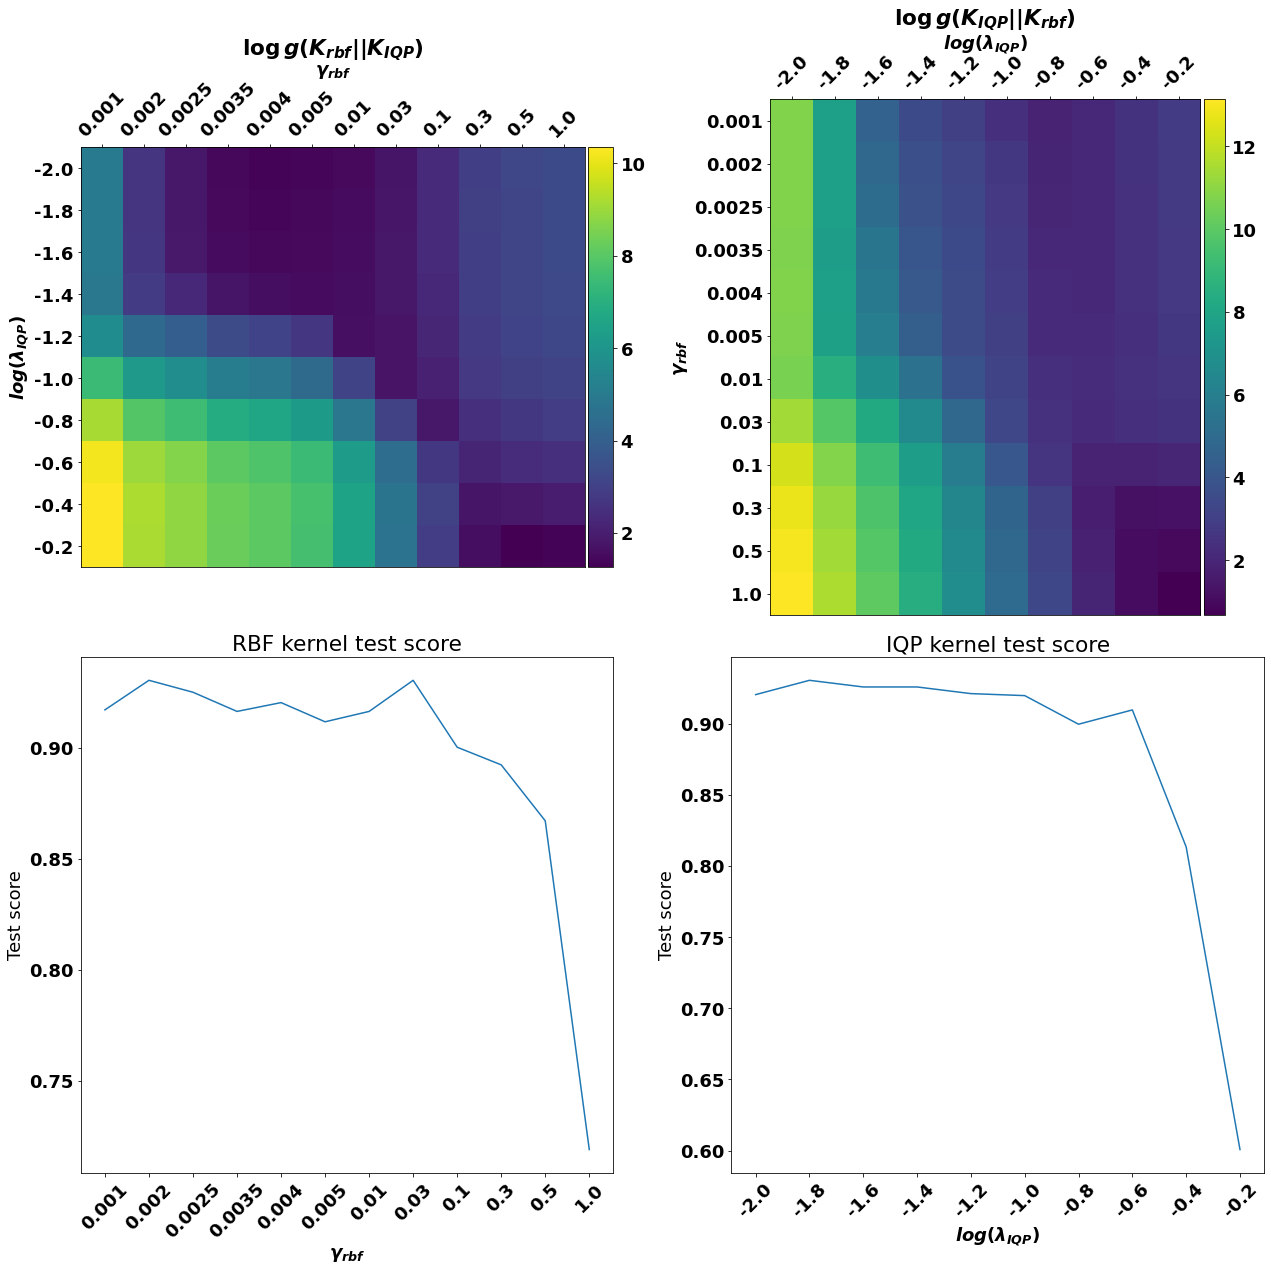

In [135]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
# Plot the geometric difference matrix
ax = axs[0][0]
img = ax.imshow(np.log(metric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(h2s.shape[0]), minor=False)
ax.set_yticklabels(h2s)
ax.set_ylabel(r'$log(\lambda_{IQP})$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$\log{g(K_{rbf}||K_{IQP})}$')
# Now plot the reverse geometric difference matrix
ax = axs[0][1]
img = ax.imshow(np.log(rmetric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(rh1s.shape[0]), minor=False)
ax.set_xticklabels(rh1s, rotation=45)
ax.set_xlabel(r'$log(\lambda_{IQP})$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(rh2s.shape[0]), minor=False)
ax.set_yticklabels(rh2s)
ax.set_ylabel(r'$\gamma_{rbf}$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$\log{g(K_{IQP}||K_{rbf})}$')
# Plot the test score as a function of gamma for the RBF kernel.
ax = axs[1][0]
x = h1s
y = np.array([rbf_df['test_score'].loc[rbf_df['gamma'] == h1].values[0]
             for h1 in h1s])
img = ax.plot(y)

ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')

ax.set_ylabel('Test score')

ax.set_title('RBF kernel test score')
# Plot the test score as a function of gamma for the Laplacian Kernel.
ax = axs[1][1]
x = h2s
y = np.array([iqp_df['test_score'].loc[iqp_df['log_scaling_factor']
             == h2].values[0] for h2 in h2s])
img = ax.plot(y)

ax.set_xticks(np.arange(h2s.shape[0]), minor=False)
ax.set_xticklabels(h2s, rotation=45)
ax.set_xlabel(r'$log(\lambda_{IQP})$')

ax.set_ylabel('Test score')

ax.set_title('IQP kernel test score')

####
# plt.subplots_adjust(hspace=-0.6,wspace=0.4)
fig.tight_layout()
fig.savefig(f'{save_folder}{dataset_name}_geometric_difference_IQP_rbf.pdf')

In [136]:
df1 = rbf_df[['gamma', 'qkern_matrix_train']]
df2 = iqp_df[['log_scaling_factor', 'qkern_matrix_train']]
# compute the metric matrix and the list of sorted hyperparameters
h1s, h2s, metric_matrix = kernel_geometry.compute_metric_matrix(df1, df2, metric='geometric_distance')


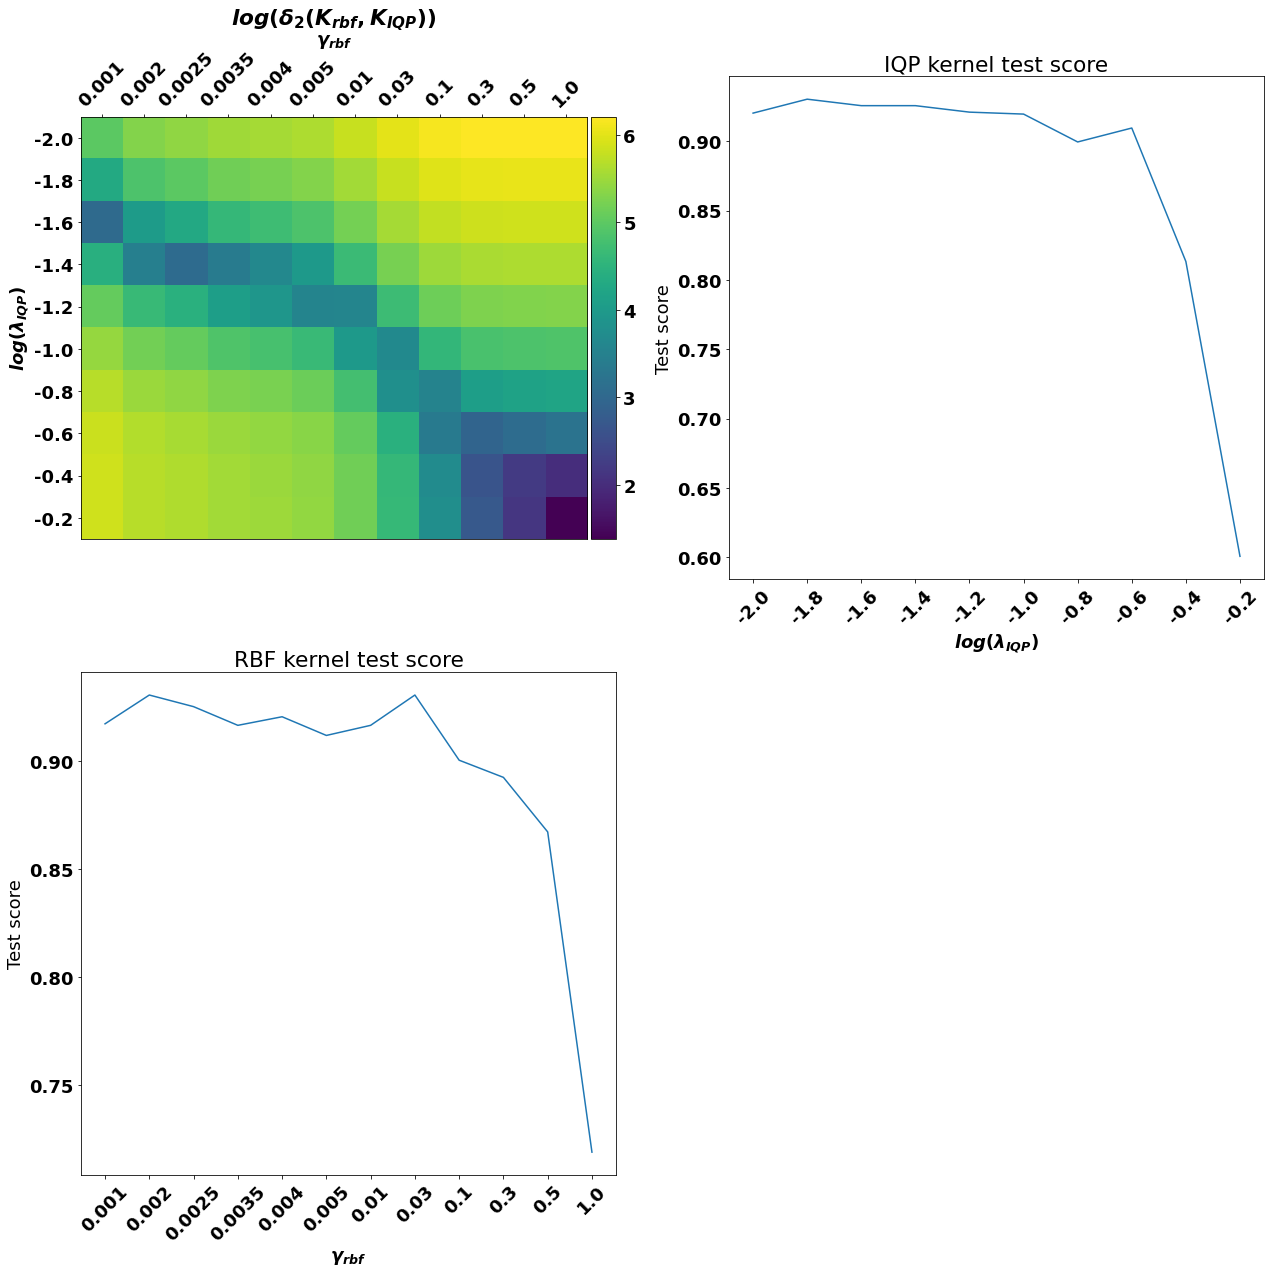

In [137]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
# Plot the geometric difference matrix
ax = axs[0][0]
img = ax.imshow(np.log(metric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(h2s.shape[0]), minor=False)
ax.set_yticklabels(h2s)
ax.set_ylabel(r'$log(\lambda_{IQP})$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$log(\delta_{2}{(K_{rbf},K_{IQP})})$')
# Plot the test score as a function of gamma for the RBF kernel.
ax = axs[1][0]
x = h1s
y = np.array([rbf_df['test_score'].loc[rbf_df['gamma'] == h1].values[0] for h1 in h1s])
img = ax.plot(y)

ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')

ax.set_ylabel('Test score')

ax.set_title('RBF kernel test score')
# Plot the test score as a function of gamma for the Laplacian Kernel.
ax = axs[0][1]
x = h2s
y = np.array([iqp_df['test_score'].loc[iqp_df['log_scaling_factor']== h2].values[0] for h2 in h2s])
img = ax.plot(y)

ax.set_xticks(np.arange(h2s.shape[0]), minor=False)
ax.set_xticklabels(h2s, rotation=45)
ax.set_xlabel(r'$log(\lambda_{IQP})$')

ax.set_ylabel('Test score')

ax.set_title('IQP kernel test score')

####
# plt.subplots_adjust(hspace=-0.6,wspace=0.4)
fig.delaxes(axs[1][1])
fig.tight_layout()
fig.savefig(f'{save_folder}{dataset_name}_geometric_distance_IQP_rbf.pdf')

In [138]:
df1 = rbf_df[['gamma', 'qkern_matrix_train']]
df2 = iqp_df[['log_scaling_factor', 'qkern_matrix_train']]
# compute the metric matrix and the list of sorted hyperparameters
h1s, h2s, metric_matrix = kernel_geometry.compute_metric_matrix(df1, df2, metric='grassmann_distance')

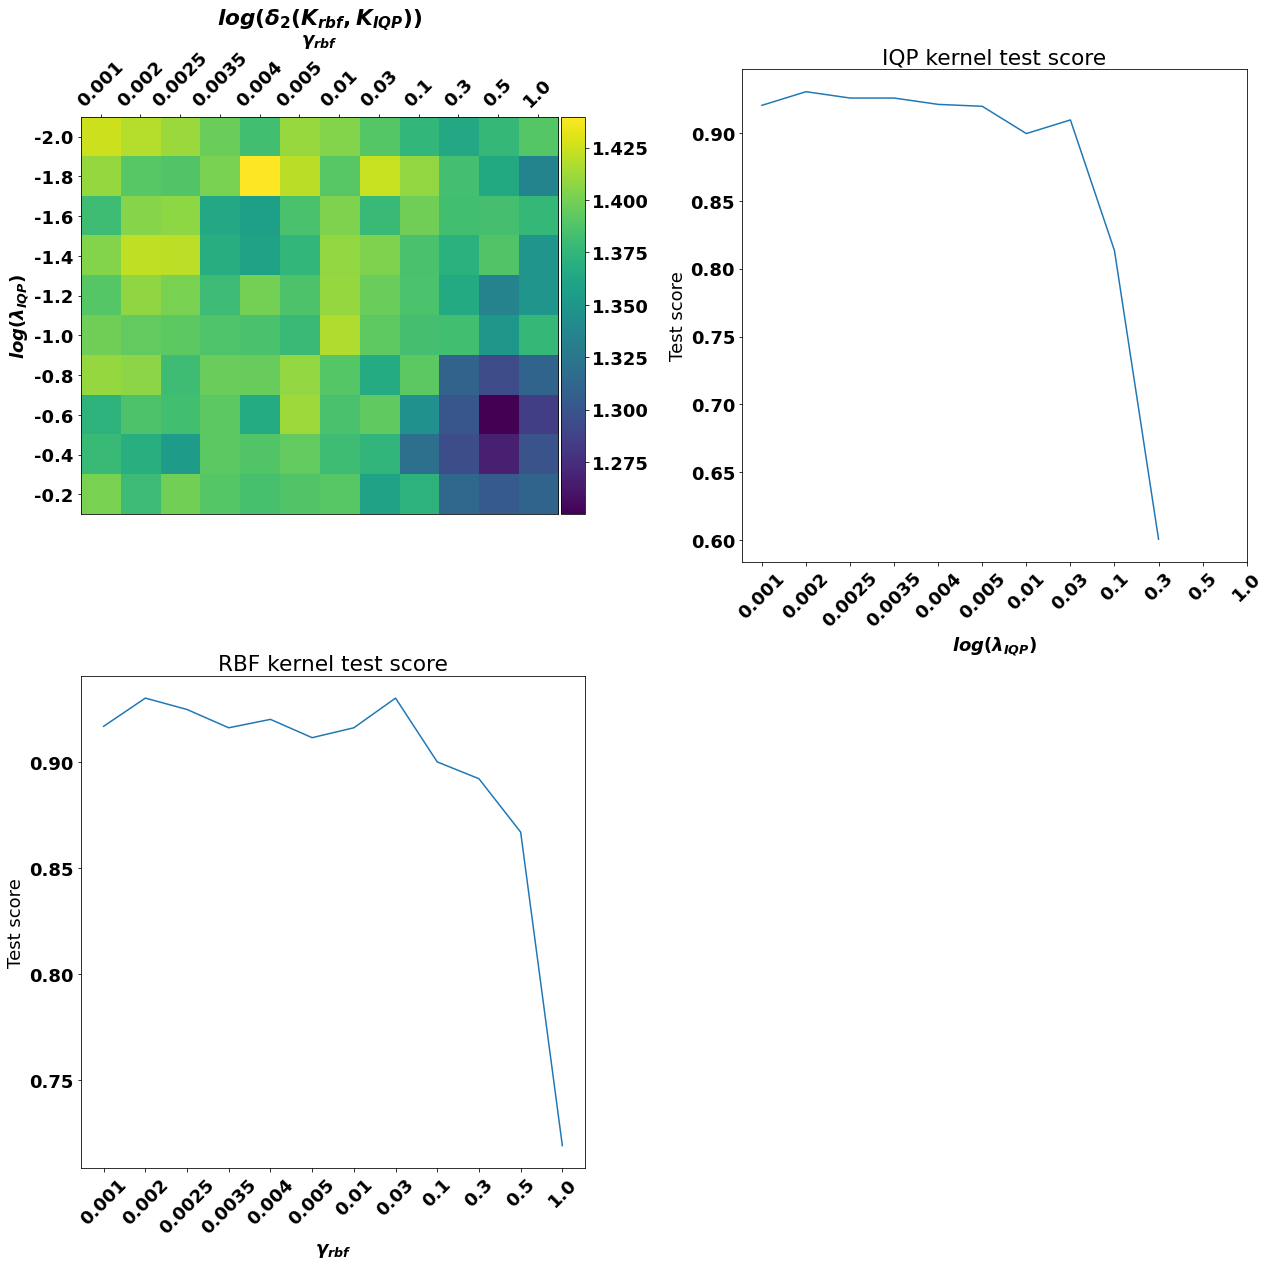

In [139]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
# Plot the geometric difference matrix
ax = axs[0][0]
img = ax.imshow(np.log(metric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(h2s.shape[0]), minor=False)
ax.set_yticklabels(h2s)
ax.set_ylabel(r'$log(\lambda_{IQP})$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$log(\delta_{2}{(K_{rbf},K_{IQP})})$')
# Plot the test score as a function of gamma for the RBF kernel.
ax = axs[1][0]
x = h1s
y = np.array([rbf_df['test_score'].loc[rbf_df['gamma'] == h1].values[0]
             for h1 in h1s])
img = ax.plot(y)

ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$\gamma_{rbf}$')

ax.set_ylabel('Test score')

ax.set_title('RBF kernel test score')
# Plot the test score as a function of gamma for the Laplacian Kernel.
ax = axs[0][1]
x = h2s
y = np.array([iqp_df['test_score'].loc[iqp_df['log_scaling_factor']
             == h2].values[0] for h2 in h2s])
img = ax.plot(y)

ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$log(\lambda_{IQP})$')

ax.set_ylabel('Test score')

ax.set_title('IQP kernel test score')

####
# plt.subplots_adjust(hspace=-0.6,wspace=0.4)
fig.delaxes(axs[1][1])
fig.tight_layout()
fig.savefig(f'{save_folder}{dataset_name}_grassmann_distance_IQP_rbf.pdf')